## DGCCA for EHR dataset

There are several ways to run DGCCA in EHR dataset:

1. Use each patient data as an example. Use diagnosis, procedure and medication as three different views of the tensor. See if people with similar diagnosis cluster?

2. Use diagnosis vs procedure view. Each diagnosis is an example. Each procedure is a feature. 

3. Use diagnosis vs medication view.
    

In [1]:
import torch
from utils.dataset_ehr import EhrDataset

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_pr_520')


In [60]:
_, labeled_data = torch.load('/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views')

In [79]:
labeled_data[1]

OrderedDict([(('E8888', '73730'), [0, 0, 0]),
             (('E8888', '1962'), [0, 1, 0]),
             (('E8888', '78097'), [0, 2, 0]),
             (('E8888', '25062'), [0, 3, 0]),
             (('E8888', 'V145'), [0, 4, 0]),
             (('E8888', '4241'), [0, 5, 0]),
             (('E8888', '49322'), [0, 6, 0]),
             (('E8888', '4779'), [0, 7, 0]),
             (('E8888', '3384'), [0, 8, 0]),
             (('E8888', '27541'), [0, 9, 0]),
             (('E8888', '19889'), [0, 10, 0]),
             (('E8888', '6256'), [0, 11, 0]),
             (('E8888', '43330'), [0, 12, 0]),
             (('E8888', '7837'), [0, 13, 0]),
             (('E8888', '42741'), [0, 14, 0]),
             (('E8888', 'E9320'), [0, 15, 0]),
             (('E8888', '48241'), [0, 16, 0]),
             (('E8888', '340'), [0, 17, 0]),
             (('E8888', '78052'), [0, 18, 0]),
             (('E8888', '70719'), [0, 19, 0]),
             (('E8888', 'V451'), [0, 20, 0]),
             (('E8888', '07070'),

In [77]:
torch.randint(100, (1,1)).item()

68

In [69]:
torch.floor(23.3)

TypeError: floor(): argument 'input' (position 1) must be Tensor, not float

In [7]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA
from utils.synth_data_toy_2d import create_synthData
import pprint as pp
from utils.qsgd import qsgd
from utils.dataset_ehr import EhrDataset

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_ehr_diag_med_fed_1.model', help="Destination model path")
parser.add_argument('--random_seed', default=4328, help='')

args = vars(parser.parse_args(args = []))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    inner_epochs = [10],
    quant = [True], 
    rand_compress=[True], 
    n_bits=[4]
)

# mat, labeled_data = torch.load('/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/combined_views')

ehr_dataset = EhrDataset(data_file='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_med_1045',
                         shuffle=True)
all_data = list(ehr_dataset.x)
mat = ehr_dataset.x
layer_sizes_list = 3*[[512, 256, 20]]
input_size_list = 3*[mat[0].shape[1]]

run_count = 0
models = []

run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
  
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = DeepGCCA(layer_sizes_list, input_size_list)
    dgcca = dgcca.to(device)
        
    train_views = [item.double().to(device) for item in mat]
#     train_views = list(ehr_dataset.x.to(device))
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)

    criterion = run.loss_func()
    
    # init G
    dgcca.eval()
    out = dgcca(train_views)
    out = torch.stack(out)  
    out - out.mean(dim=1).unsqueeze(dim=1)
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    dgcca.train()
    G_serv = G.clone().to('cuda')
    for epoch in trange(250):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        for j in range(run.inner_epochs):

            optimizer.zero_grad()
            batch = []

            # full gradient
            batch = train_views
            target = G

            out = dgcca(batch)
            out = torch.stack(out)  

            loss = 1/2*torch.norm(out-target)/target.shape[0]

            loss.backward()
            optimizer.step()

            total_recons_loss += loss.item()
            del batch, target
        ## Update G
        dgcca.eval()
        out = dgcca(train_views)
        out = torch.stack(out)
        if run.quant:
            for i in range(len(train_views)):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                
                if run.rand_compress:
                    M_quant = qsgd(M_diff[i], n_bits=run.n_bits).to(device)
                else:
                    M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                    
                M_serv[i] += M_quant
                M_serv[i] -= M_serv[i].mean(dim=0)
                del M_quant, max_val
            G = g_step(M_serv.clone().detach()) 
            G_serv = G_serv + qsgd(G-G_serv).to(device)
        else:
            out = out- out.mean(dim=1).unsqueeze(dim=1)
            G = g_step(out.clone().detach())  
        del out
        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        display(df2)

        torch.save(dgcca, args['model_dest'])

,run_count,epoch,data_fidelity,lr,device
0,1,0,0.164986,0.001,cuda
1,1,1,0.051493,0.001,cuda
2,1,2,0.041662,0.001,cuda
3,1,3,0.038917,0.001,cuda
4,1,4,0.037263,0.001,cuda
...,...,...,...,...,...
163,1,163,0.010376,0.001,cuda
164,1,164,0.009541,0.001,cuda
165,1,165,0.010226,0.001,cuda
166,1,166,0.010096,0.001,cuda


 67%|██████▋   | 168/250 [01:00<00:29,  2.78it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 9.28 GiB already allocated; 3.00 MiB free; 10.10 GiB reserved in total by PyTorch)

In [14]:
ehr_dataset.x.shape

torch.Size([3, 1045, 511])

In [13]:
out.mean(dim=1).unsqueeze(dim=1).shape

torch.Size([3, 1, 20])

In [11]:
mat[0].shape

torch.Size([1045, 511])

In [13]:
all_data[0].shape

torch.Size([1045, 511])

In [2]:
parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='trained_models/dgcca_ehr_diag_med_fed_1.model', help="Destination model path")
parser.add_argument('--random_seed', default=4328, help='')

args = vars(parser.parse_args(args = []))
pp.pprint(args)

dgcca = torch.load(args['model_dest'])

{'model_dest': 'trained_models/dgcca_ehr_diag_med_fed_1.model',
 'random_seed': 4328}


## Plot TSNE 

Text(0.5, 1.0, 't-SNE plot of latent representation G')

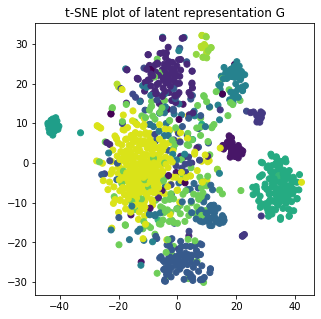

In [9]:
import numpy as np
from sklearn.manifold import TSNE
# from ehr.prep_data import get_classes_list_from_dict


# classes = get_classes_list_from_dict(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/combined_views')
# dgcca.eval().to('cpu')
# test_views = ehr_dataset.x[:,800:,...]
# y = ehr_dataset.y[800:]
# test_views = list(test_views)
# test_views = [item.double().to('cpu') for item in test_views]
# out = dgcca(test_views)
# out = torch.stack(out)
# G = g_step(out.clone().detach())

X = G.to('cpu').numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1, figsize=(5,5))

sc = axes.scatter(X_embedded[:,0], X_embedded[:,1], c=ehr_dataset.y)
# plt.legend(handles=sc.legend_elements()[0], 
#            labels=list(range(18)),
#            title="species")
axes.set_title('t-SNE plot of latent representation G')

In [9]:
X.shape

(1045, 20)

In [8]:
a = []
for i in range(len(ehr_dataset.y)):
    if ehr_dataset.y[i] not in a:
        a.append(ehr_dataset.y[i])

In [11]:
a

[tensor(12),
 tensor(18),
 tensor(6),
 tensor(9),
 tensor(3),
 tensor(8),
 tensor(15),
 tensor(4),
 tensor(7),
 tensor(5),
 tensor(1),
 tensor(16),
 tensor(11),
 tensor(17),
 tensor(2),
 tensor(13)]

In [7]:
len(ehr_dataset.y)

1045

Text(0.5, 1.0, 't-SNE plot of latent representation G')

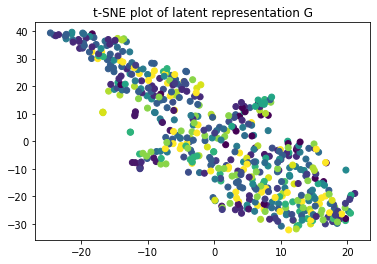

In [57]:
import numpy as np
from sklearn.manifold import TSNE
# from ehr.prep_data import get_classes_list_from_dict

# classes = get_classes_list_from_dict(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/combined_views')
X = dat.detach().to('cpu').numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1)

axes.scatter(X_embedded[:,0], X_embedded[:,1], c=classes)
axes.set_title('t-SNE plot of latent representation G')

In [56]:
def get_diagnosis_classes_list_from_dict(filename=None, data=None):
    """
    Get CMS classes from the ordered dictionary with keys as tuple of (diagnosis, category2)
    returns a list of classes index
    """
    if filename is not None:
        _, data = torch.load(filename)

    if isinstance(data, list):
        data = data[0]
    
    classes = []
    cl_list = ((100, 139), 
            (140, 239), 
            (240, 289),
            (290, 319),
            (320, 389),
            (390, 459), 
            (460, 519),
            (520, 579),
            (580, 629),
            (630, 679),
            (680, 709),
            (710, 739),
            (740, 759),
            (760, 779),
            (780, 799),
            (800, 999))

    keys = list(data.keys())
    num_rows = data[keys[-1]][0]+1
    num_cols = data[keys[-1]][1]+1
    classes = [0]*num_rows
    for i in range(num_rows):
        if keys[i*num_cols][0].startswith('0'):
            classes[i] = 1
        elif keys[i*num_cols][0].startswith('E'):
            classes[i] = 17
        elif keys[i*num_cols][0].startswith('V'):
            classes[i] = 18
        else:
            num = int(keys[i*num_cols][0][:3])
            for j in range(len(cl_list)):
                if num >= cl_list[j][0] and num <= cl_list[j][1]:
                    classes[i] = j+1
    return classes

classes = get_diagnosis_classes_list_from_dict(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views')

In [13]:
torch.save((mat, classes), "/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/diag_pr_520")

In [38]:
def redefine_features(filename=None):
    """
    Get CMS classes from the ordered dictionary with keys as tuple of (diagnosis, category2)
    returns a list of classes index
    """
    filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views'
    mat, data = torch.load(filename)
    num_classes = 18
    new_mat = torch.zeros(len(mat), mat[0].shape[0], num_classes)
    if isinstance(data, list):
        data = data[0]

    classes = []
    cl_list = ((100, 139), 
            (140, 239), 
            (240, 289),
            (290, 319),
            (320, 389),
            (390, 459), 
            (460, 519),
            (520, 579),
            (580, 629),
            (630, 679),
            (680, 709),
            (710, 739),
            (740, 759),
            (760, 779),
            (780, 799),
            (800, 999))

    keys = list(data.keys())
    num_rows = data[keys[-1]][0]+1
    num_cols = data[keys[-1]][1]+1
    classes = [[] for i in range(num_classes)]
    #     classes = [0]*num_rows

    for i in range(num_cols):

        if keys[i][1].startswith('0'):
            classes[0].append(i)
        elif keys[i][1].startswith('E'):
            classes[16].append(i)
        elif keys[i][1].startswith('V'):
            classes[17].append(i)
        else:
            num = int(keys[i][1][:3])
            for j in range(len(cl_list)):
                if num >= cl_list[j][0] and num <= cl_list[j][1]:
                    classes[j].append(i)
    for view in range(len(mat)):
        for cl in range(num_classes):
            new_mat[view,:,cl] = mat[view][:,classes[cl]].sum(dim=-1)

    return new_mat

new_mat = redefine_features(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/dictionary_data/combined_views')

In [39]:
new_mat[0][:100,..., 2]

tensor([23., 24., 18., 30., 20., 39., 18., 22., 13., 26., 15., 30., 35.,  5.,
        35., 37., 28., 85., 23., 14., 26., 21., 25., 55., 39., 13., 90., 45.,
        32., 21., 62., 17., 23., 15., 23., 31., 31., 26., 20., 36., 17., 24.,
        19., 34., 29., 27., 39., 23., 17., 18., 10., 45., 44., 31., 20., 24.,
        20., 20., 21., 40., 32., 23., 10., 36., 22., 60., 25., 35., 66., 20.,
        29.,  9., 26., 22., 29., 17., 39., 28., 37., 21., 20., 30., 24., 28.,
        23., 59., 15., 29., 20., 84., 51., 45., 25., 52., 52., 15., 66., 21.,
        52., 30.])

In [44]:
new_mat[0]

tensor([[ 2.,  0., 23.,  ...,  1.,  3.,  5.],
        [ 0.,  0., 24.,  ...,  1.,  0., 18.],
        [ 0.,  1., 18.,  ...,  4.,  1., 10.],
        ...,
        [ 1.,  0., 12.,  ...,  6.,  2.,  3.],
        [ 0.,  0., 13.,  ...,  3.,  3.,  7.],
        [ 6.,  3., 19.,  ...,  5.,  2.,  5.]])

In [52]:
mean = torch.mean(new_mat[0], dim=0) + 1e-10
dat = torch.div(new_mat[0], mean[None,:])

In [54]:
mean 

tensor([7.7923e+00, 5.8981e+00, 1.3183e+02, 2.3279e+01, 2.1090e+01, 1.8202e+02,
        4.4321e+01, 2.8383e+01, 4.7660e+01, 1.0000e-10, 9.8423e+00, 1.9406e+01,
        1.0000e-10, 1.0000e-10, 2.2733e+01, 1.6910e+01, 8.4500e+00, 5.5810e+01])

In [ ]:
torch.div

In [33]:
classes = [[]]*num_classes
cl

IndexError: list index out of range

In [32]:
classes

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]]

In [13]:
a

tensor([[0.2005, 0.2670, 0.8861, 0.4979],
        [0.1635, 0.4009, 0.9210, 0.6054],
        [0.9128, 0.6891, 0.8614, 0.2059],
        [0.1353, 0.9990, 0.2122, 0.0941],
        [0.9158, 0.4575, 0.9928, 0.6441]])

In [15]:
a.sum(dim=1)

tensor([1.8516, 2.0909, 2.6691, 1.4406, 3.0101])

In [9]:
a

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [7]:
get

[OrderedDict([(('E8888', '73730'), [0, 0, 0]),
              (('E8888', '1962'), [0, 1, 0]),
              (('E8888', '78097'), [0, 2, 0]),
              (('E8888', '25062'), [0, 3, 0]),
              (('E8888', 'V145'), [0, 4, 0]),
              (('E8888', '4241'), [0, 5, 0]),
              (('E8888', '49322'), [0, 6, 0]),
              (('E8888', '4779'), [0, 7, 0]),
              (('E8888', '3384'), [0, 8, 0]),
              (('E8888', '27541'), [0, 9, 1]),
              (('E8888', '19889'), [0, 10, 0]),
              (('E8888', '6256'), [0, 11, 0]),
              (('E8888', '43330'), [0, 12, 0]),
              (('E8888', '7837'), [0, 13, 0]),
              (('E8888', '42741'), [0, 14, 0]),
              (('E8888', 'E9320'), [0, 15, 0]),
              (('E8888', '48241'), [0, 16, 0]),
              (('E8888', '340'), [0, 17, 0]),
              (('E8888', '78052'), [0, 18, 0]),
              (('E8888', '70719'), [0, 19, 0]),
              (('E8888', 'V451'), [0, 20, 0]),
            

In [42]:

def get_classes_list_from_dict(filename='/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/view1_1000_500'):
    """
    Get CMS classes from the ordered dictionary with keys as tuple of (diagnosis, category2)
    returns a list of classes index
    """
    _, data = torch.load(filename)
    if isinstance(data, list):
        data = data[0]
    classes = []
    cl_list = ((100, 139), 
            (140, 239), 
            (240, 289),
            (290, 319),
            (320, 389),
            (390, 459), 
            (460, 519),
            (520, 579),
            (580, 629),
            (630, 679),
            (680, 709),
            (710, 739),
            (740, 759),
            (760, 779),
            (780, 799),
            (800, 999))

    keys = list(data.keys())
    num_rows = data[keys[-1]][0]+1
    num_cols = data[keys[-1]][1]+1
    classes = [0]*num_rows
    for i in range(num_rows):
        if keys[i*num_cols][0].startswith('0'):
            classes[i] = 1
        elif keys[i*num_cols][0].startswith('E'):
            classes[i] = 17
        elif keys[i*num_cols][0].startswith('V'):
            classes[i] = 18
        else:
            num = int(keys[i*num_cols][0][:3])
            for j in range(len(cl_list)):
                if num >= cl_list[j][0] and num <= cl_list[j][1]:
                    classes[i] = j+1

    return classes

In [2]:
import torch
mat,_ = torch.load('/scratch/sagar/Projects/federated_max_var_gcca/ehr/data/combined_views')


In [8]:
from models import DeepGCCA
layer_sizes_list = 3*[[512, 256, 20]]
input_size_list = 3*[mat[0].shape[1]]
dgcca = DeepGCCA(layer_sizes_list, input_size_list)


In [12]:
out = dgcca([item.double() for item in mat])

In [16]:
out = torch.stack(out)

In [17]:
out.shape

torch.Size([3, 520, 20])

In [24]:
a = out - out.mean(dim=1).unsqueeze(dim=1)

In [26]:
torch.norm(a.mean(dim=1) - 0)

tensor(1.2666e-16, dtype=torch.float64, grad_fn=<CopyBackwards>)

In [14]:
out[0].shape

torch.Size([520, 20])

In [7]:
mat[0].shape

torch.Size([520, 339])